# 目的：チョコボールの商品別の重量比較
## アプローチ
- 正味重量をベイズ推定し、その傾向の違いを比較する

## モデル
- 重量分布は正規分布であると仮定する
- 事前分布は平均が仕様の正規分布とする（分散を大きくして一様分布みたいなものとする）

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

import pymc as pm

import ChocoUtils as cu

# データをロードする
- mysqlに貯めているデータをロード
- ヒストグラムを描画してみる

In [2]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0, 1, 4, 7, 10, 11, 12)")
#data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0, 1, 10, 11, 12)")
#data = cu.get_data(db_file='../../data/choco-ball.db')
grp = data.groupby(['taste'])
grp.count()[['weight']]

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste in (0, 1, 4, 7, 10, 11, 12);
Shape of MeasurementData(record_num, n_columns) : (372, 14)


,weight
taste,
0,302
1,14
4,10
7,10
10,11
11,14
12,11


# 基礎集計

## ヒストグラム

In [3]:
# 仕様の重量
spec = {0: 28.0, 1: 25.0, 4: 22.0, 7: 26.0, 10: 22.0, 11: 22.0, 12: 22.0}
taste_name = {0: "peanut", 1: "strawberry", 4: "ama-zake",
              7: "pachi-pachi", 10: "pineapple", 11: "milk-caramel", 12: "choco-banana"}

/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


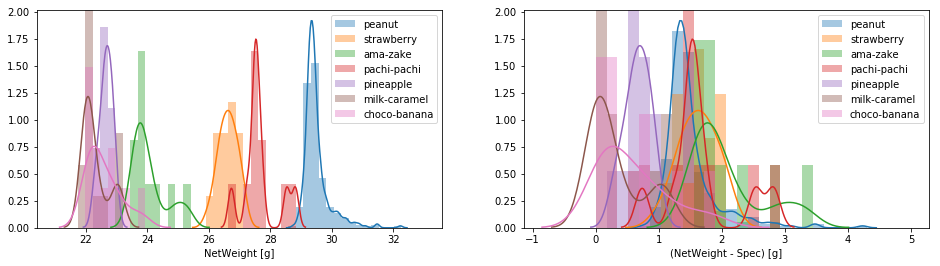

In [4]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 5.0, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=np.linspace(21, 33, 50), hist=True, label=taste_name[key], ax=ax[0])
    sns.distplot((value["net_weight"] - spec[key]), bins=bins, hist=True, label=taste_name[key], ax=ax[1])
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()
fig.savefig("weight_histogram.png")

# 正規分布のパラメータを予測

## MCMCによるベイズ推定
### モデルの設定

In [5]:
def getEstimatedWeightDist(values, spec, n_sample=15000, n_burn=5000):
    # 精度$\tau$(分散の逆数)
    tau = 1.0 / pm.Uniform("std", 0, 100)**2
    # 分布の中心
    ## 事前分布の中心として製品仕様を、tauを0.01(分散=100)
    center = pm.Normal("center", spec, 0.01)
    # 観測とモデルを結びつける
    observations = pm.Normal("obs", center, tau, value=values, observed=True)
    # Modelオブジェクト生成
    model = pm.Model([tau, center])
    
    # MCMC
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)
    
    return mcmc.trace("center")[:], mcmc.trace("std")[:]

 [-----------------100%-----------------] 15000 of 15000 complete in 1.6 sec

/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


 [-----------------100%-----------------] 15000 of 15000 complete in 1.4 sec

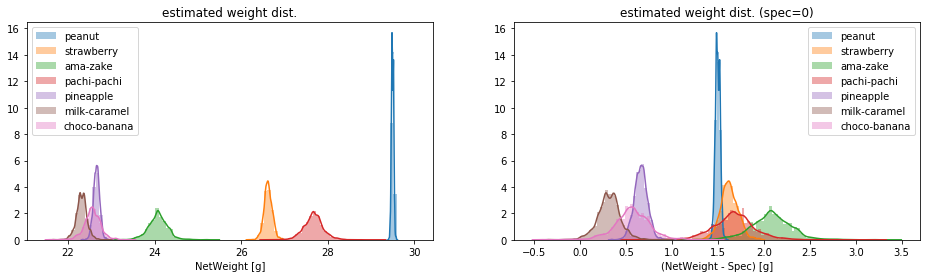

In [6]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 3.0, 100)
bins_p = np.linspace(22.0, 30.0, 100)
result_dict = dict()
for key, value in grp:
    e_center, e_std = getEstimatedWeightDist(values=value['net_weight'].values, spec=spec[key])
    sns.distplot(e_center, bins=bins_p, label=taste_name[key], ax=ax[0])
    sns.distplot((e_center-spec[key]), bins=bins, label=taste_name[key], ax=ax[1])
    result_dict[key] = e_center
ax[0].set_title('estimated weight dist.')
ax[1].set_title('estimated weight dist. (spec=0)')
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()
fig.savefig("weight_estimate_bayes.png")

 [-----------------100%-----------------] 15000 of 15000 complete in 1.8 sec

/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


 [-----------------100%-----------------] 15000 of 15000 complete in 1.4 sec

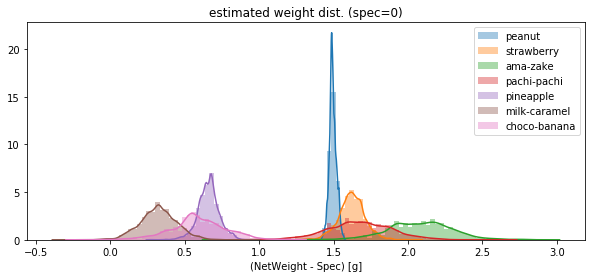

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

bins = np.linspace(0, 3.0, 100)
bins_p = np.linspace(22.0, 30.0, 100)
result_dict = dict()
for key, value in grp:
    e_center, e_std = getEstimatedWeightDist(values=value['net_weight'].values, spec=spec[key])
    sns.distplot((e_center-spec[key]), bins=bins, label=taste_name[key], ax=ax)
    result_dict[key] = e_center
ax.set_title('estimated weight dist. (spec=0)')
ax.set_xlabel("(NetWeight - Spec) [g]")
ax.legend()
fig.savefig("weight_estimate_bayes_d.png")

In [8]:
for k, v in result_dict.items():
    e1 = v.mean()
    e2 = (v - spec[k]).mean()
    print('| {} | {} | {} |'.format(taste_name[k], e1, e2))

| peanut | 29.49574812104699 | 1.4957481210469923 |
| strawberry | 26.623127968940725 | 1.6231279689407285 |
| ama-zake | 24.08030679958805 | 2.0803067995880493 |
| pachi-pachi | 27.674573887435447 | 1.674573887435445 |
| pineapple | 22.660631900157355 | 0.6606319001573544 |
| milk-caramel | 22.324170785759023 | 0.32417078575902264 |
| choco-banana | 22.591700966719156 | 0.5917009667191565 |


In [9]:
for k, v in result_dict.items():
    e2 = (v - spec[k]).mean()
    l, u = np.percentile((v - spec[k]), (5, 95))
    print('| {} | {} | {} | {} |'.format(taste_name[k], l, e2, u))

| peanut | 1.4574843408725897 | 1.4957481210469923 | 1.5380789521781004 |
| strawberry | 1.4693015114088084 | 1.6231279689407285 | 1.772616398557762 |
| ama-zake | 1.7105427944054021 | 2.0803067995880493 | 2.420720282456388 |
| pachi-pachi | 1.3128460795574775 | 1.674573887435445 | 2.0347874646712967 |
| pineapple | 0.5414303593044067 | 0.6606319001573544 | 0.7843510612367943 |
| milk-caramel | 0.11801204816226019 | 0.32417078575902264 | 0.5244194951781544 |
| choco-banana | 0.2709590893000972 | 0.5917009667191565 | 0.9072060339975963 |


 [-----------------100%-----------------] 15000 of 15000 complete in 1.4 sec

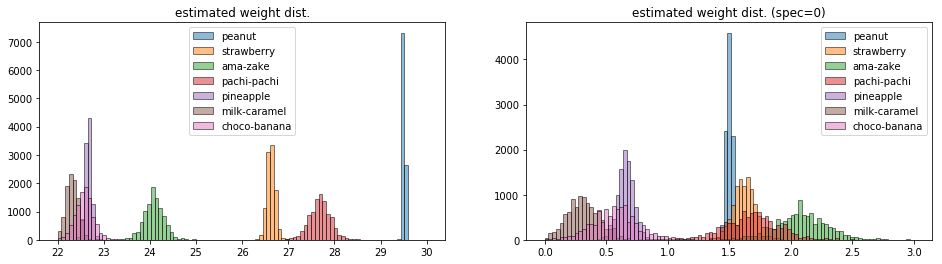

In [10]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 3.0, 100)
bins_p = np.linspace(22.0, 30.0, 100)
for key, value in grp:
    e_center, e_std = getEstimatedWeightDist(values=value['net_weight'].values, spec=spec[key])
    ax[0].hist(e_center, bins=bins_p, alpha=0.5, edgecolor="#000000", lw=1, label=taste_name[key])
    ax[1].hist((e_center-spec[key]), bins=bins, alpha=0.5, edgecolor="#000000", lw=1, label=taste_name[key])
ax[0].set_title('estimated weight dist.')
ax[1].set_title('estimated weight dist. (spec=0)')
ax[0].legend()
ax[1].legend()
